In [1]:
import dicom
import os
import numpy as np
from skimage.draw import polygon
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
from AlgoEngine.utils import getContours, getImageBlock, convertROIToCTSpace
from General.testing_utils import getContourInputs

## Generating Inputs to Function

In [2]:
BASE_DIR = '/home/radiation/RadiationTherapyDecisionSupport/data/'
StudyID = 'UCLA_PR_6'
ROI_NAME = 'BODY'

block_shape, contour_data, image_orientation, image_position, pixel_spacing = getContourInputs(BASE_DIR, StudyID, ROI_NAME, excluding=[])

## Function

We call our created function, getContours, and generate the results as described in the docstring.

In [3]:
contour_block, roi_block = getContours(block_shape, contour_data, image_orientation, image_position, pixel_spacing)

## Testing

We now draw some sample contours on images to confirm the functions work as intended. First, we render a sample image of a contour (the contour is in red).

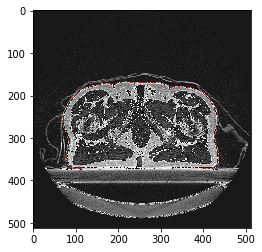

In [4]:
index = 159
image_block, sop_ids = getImageBlock(StudyID, BASE_DIR)

sop_id = list(sop_ids.items())[index][1]
imagei = image_block[:, :, index]

rgb_image = np.zeros((imagei.shape[0], imagei.shape[1], 3)).astype(np.uint8)

mask = convertROIToCTSpace(contour_block, image_position, sop_ids)[:, :, index]

for chan in range(0, 3):
    rgb_image[:, :, chan] = imagei
    if chan == 0:
        rgb_image[mask == 1, chan] = 255
    else:
        rgb_image[mask == 1, chan] = 0 

plt.imshow(rgb_image, cmap='gray')
plt.show()


Next, we render an image with the filled in contour (ROI).

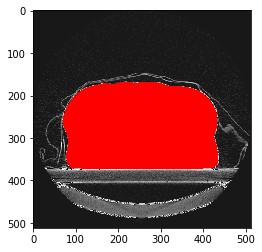

In [5]:
rgb_image = np.zeros((imagei.shape[0], imagei.shape[1], 3)).astype(np.uint8)

mask = convertROIToCTSpace(roi_block, image_position, sop_ids)[:, :, index]

for chan in range(0, 3):
    rgb_image[:, :, chan] = imagei
    if chan == 0:
        rgb_image[mask == 1, chan] = 255
    else:
        rgb_image[mask == 1, chan] = 0 

plt.imshow(rgb_image, cmap='gray')
plt.show()